# Import Libraries

In [1]:
from __future__ import print_function
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchsummary import summary
from torch.autograd import Variable

from torchvision import datasets, transforms
import torchvision

import sys, os
import matplotlib.pyplot as plt

import resnet

from utils import create_train_data_loader, create_test_data_loader
from utils import Cifar10SearchDataset
from utils import train_transforms, test_transforms
from utils import display_mis_images 
from utils import learning_r_finder
from utils import OneCycleLR_policy

from calc_loss_accuracy import model_training, model_testing_old#, model_testing 
from plots import plot_losses,plot_images 

import warnings
warnings.filterwarnings('ignore')

/usr/local/lib/python3.8/dist-packages/torch_lr_finder/lr_finder.py:5: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  from tqdm.autonotebook import tqdm


In [2]:
### this is for running in local ###
try:
    os.environ['HTTP_PROXY']='http://185.46.212.90:80'
    os.environ['HTTPS_PROXY']='http://185.46.212.90:80'
    print ("proxy_exported")
except:
    None

proxy_exported


In [3]:
SEED = 1

# CUDA?
cuda = torch.cuda.is_available()
print("CUDA Available?", cuda)

# For reproducibility
torch.manual_seed(SEED)

if cuda:
    torch.cuda.manual_seed(SEED)
    
device = torch.device("cuda" if cuda else "cpu")
print(device)

CUDA Available? True
cuda


# Train/Test Data Loaders with Transformation

In [4]:
means = [0.4914, 0.4822, 0.4465]
stds = [0.2470, 0.2435, 0.2616]

train_transforms = train_transforms(means, stds)
test_transforms = test_transforms(means, stds)

train = Cifar10SearchDataset('./data', train=True, download=True, transform=train_transforms)
test = Cifar10SearchDataset('./data', train=False, download=True, transform=test_transforms)

dataloader_args = dict(shuffle=True, batch_size=512, num_workers=0, pin_memory=True) if cuda else dict(shuffle=True, batch_size=64)
train_loader = torch.utils.data.DataLoader(train, **dataloader_args)
test_loader = torch.utils.data.DataLoader(test, **dataloader_args)

Files already downloaded and verified
Files already downloaded and verified


# Model Params, optimizer, loss criterion and model summary
Can't emphasize on how important viewing Model Summary is.
Unfortunately, there is no in-built model visualizer, so we have to take external help

In [5]:
m = resnet.ResNet18().to(device)
optimizer = optim.Adam(m.parameters(), lr=0.001, weight_decay=1e-3)
criterion = nn.CrossEntropyLoss()
summary(m, input_size=(3, 32, 32))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 64, 32, 32]           1,728
       BatchNorm2d-2           [-1, 64, 32, 32]             128
            Conv2d-3           [-1, 64, 32, 32]          36,864
       BatchNorm2d-4           [-1, 64, 32, 32]             128
            Conv2d-5           [-1, 64, 32, 32]          36,864
       BatchNorm2d-6           [-1, 64, 32, 32]             128
        BasicBlock-7           [-1, 64, 32, 32]               0
            Conv2d-8           [-1, 64, 32, 32]          36,864
       BatchNorm2d-9           [-1, 64, 32, 32]             128
           Conv2d-10           [-1, 64, 32, 32]          36,864
      BatchNorm2d-11           [-1, 64, 32, 32]             128
       BasicBlock-12           [-1, 64, 32, 32]               0
           Conv2d-13          [-1, 128, 16, 16]          73,728
      BatchNorm2d-14          [-1, 128,

## Calculating the max and min LR using one cycle LR policy

In [6]:
 # to reset the model and optimizer to their initial state
#learning_r_finder(m,optimizer,criterion, device, train_loader, n_iters=200,  end_lr=10)
# sys.exit()

# Let's Train and test our model
### using one cycle lr policy

In [7]:
EPOCHS = 10
scheduler = OneCycleLR_policy(optimizer,train_loader,EPOCHS,peak_value=5.0,div_factor=100,final_div_factor=100,max_lr=1.83E-03)

In [8]:
for epoch in range(EPOCHS):
    print("EPOCH: "+ str(epoch)),
    train_acc,train_losses = model_training(m, device, train_loader, optimizer, scheduler, criterion)
    test_acc,test_losses,miss_classified_data = model_testing_old(m, device, test_loader, criterion)

EPOCH: 0


Loss=1.3088651895523071 LR =0.00038138098159509206 Batch_id=97 Accuracy=38.76: 100% 98/98 [00:11<00:00,  8.29it/s]



Test set: Average loss: 0.0029, Accuracy: 4999/10000 (49.99%)

EPOCH: 1


Loss=1.0964938402175903 LR =0.000744461963190184 Batch_id=97 Accuracy=55.45: 100% 98/98 [00:10<00:00,  9.26it/s]  



Test set: Average loss: 0.0025, Accuracy: 5935/10000 (59.35%)

EPOCH: 2


Loss=0.9618939161300659 LR =0.001107542944785276 Batch_id=97 Accuracy=62.91: 100% 98/98 [00:10<00:00,  9.41it/s] 



Test set: Average loss: 0.0020, Accuracy: 6411/10000 (64.11%)

EPOCH: 3


Loss=0.8665844798088074 LR =0.0014706239263803681 Batch_id=97 Accuracy=67.68: 100% 98/98 [00:10<00:00,  9.45it/s]



Test set: Average loss: 0.0033, Accuracy: 4973/10000 (49.73%)

EPOCH: 4


Loss=0.7608639001846313 LR =0.0018262656795918367 Batch_id=97 Accuracy=70.64: 100% 98/98 [00:10<00:00,  9.35it/s]



Test set: Average loss: 0.0038, Accuracy: 5006/10000 (50.06%)

EPOCH: 5


Loss=0.7160000205039978 LR =0.0014603022795918368 Batch_id=97 Accuracy=73.13: 100% 98/98 [00:10<00:00,  9.28it/s]



Test set: Average loss: 0.0014, Accuracy: 7553/10000 (75.53%)

EPOCH: 6


Loss=0.6201191544532776 LR =0.0010943388795918367 Batch_id=97 Accuracy=76.53: 100% 98/98 [00:10<00:00,  9.30it/s]



Test set: Average loss: 0.0014, Accuracy: 7663/10000 (76.63%)

EPOCH: 7


Loss=0.5773170590400696 LR =0.0007283754795918368 Batch_id=97 Accuracy=79.20: 100% 98/98 [00:10<00:00,  9.33it/s] 



Test set: Average loss: 0.0013, Accuracy: 7640/10000 (76.40%)

EPOCH: 8


Loss=0.5398496389389038 LR =0.0003624120795918367 Batch_id=97 Accuracy=82.06: 100% 98/98 [00:10<00:00,  9.41it/s]  



Test set: Average loss: 0.0009, Accuracy: 8521/10000 (85.21%)

EPOCH: 9


Loss=0.4730796217918396 LR =-3.551320408163401e-06 Batch_id=97 Accuracy=85.01: 100% 98/98 [00:10<00:00,  9.11it/s] 



Test set: Average loss: 0.0007, Accuracy: 8890/10000 (88.90%)



## Displaying Train Test Accuracy and Loss Plots

mkdir: cannot create directory ‘images’: File exists


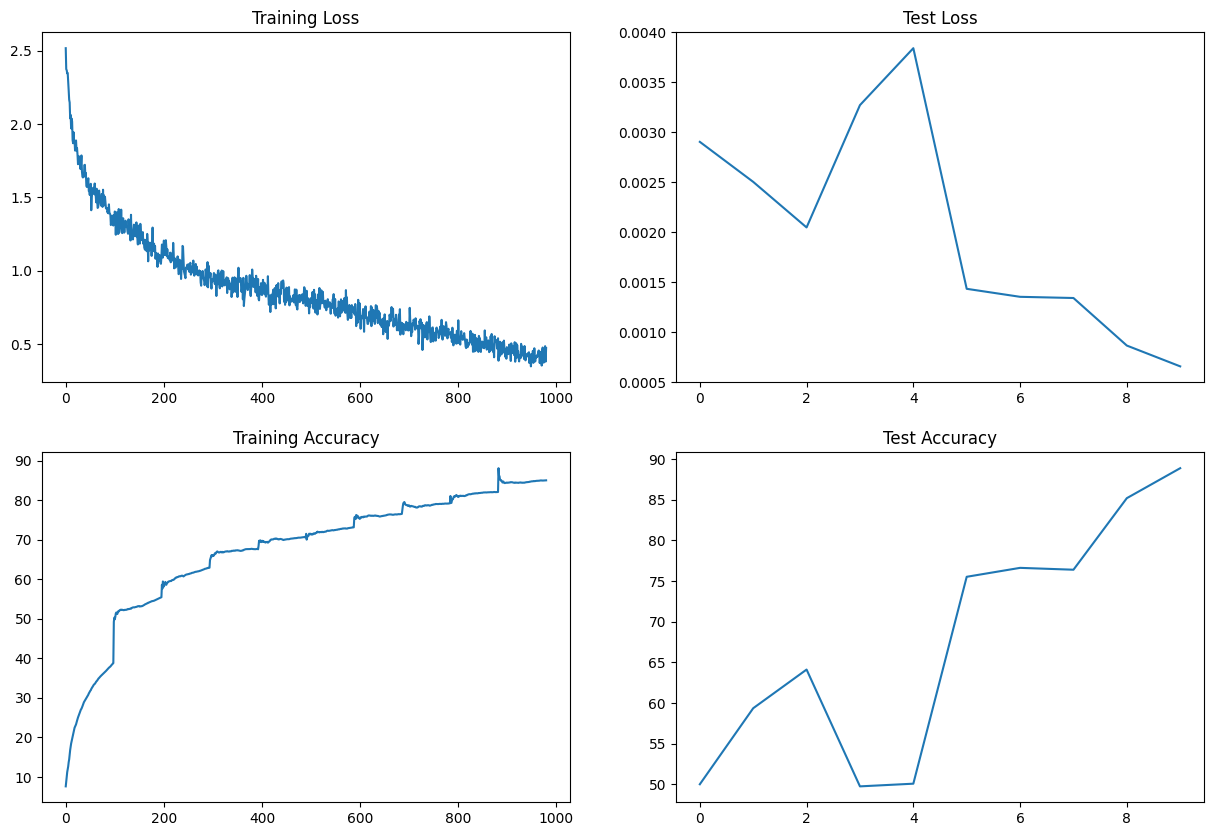

In [9]:
os.system('mkdir images')
fig = plot_losses(train_losses, train_acc, test_losses, test_acc)
fig.savefig('images/Accuracy & Loss.jpg')

In [ ]:
miss_classified_data.shape

In [ ]:
import random
random_images = range(0, len(miss_classified_data[0]))
random_selects = random.sample(random_images, 10)
for i in miss_classified_data:
    print (i)

In [ ]:
sys.exit()

In [ ]:
import random

def imshow(img):
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()


def display_mis_images(miss_classified_data, n_images):
    random_images = range(0, len(miss_classified_data[0]))
    random_selects = random.sample(random_images, n_images)

    fig_miss_class = plt.figure()
    count = 0
    for i in random_selects:
        plt.subplot(2, int(n_images/2), count+1)
        plt.imshow(miss_classified_data[2][i].cpu().permute(1, 2, 0))
        plt.title("p=" + str(miss_classified_data[1][i]) + "   " + "a=" + str(miss_classified_data[0][i]))
        plt.xticks([])
        plt.yticks([])
        count += 1

    return fig_miss_class
miss_classified_images = display_mis_images(miss_classified_data,10)

def display_mis_images(miss_classified_data, n_images):
    random_images = range(0, len(miss_classified_data))
    random_selects = random.sample(random_images, n_images)

    fig_miss_class = plt.figure()
    count = 0
    for i in random_selects:
        image = miss_classified_data[i][:3].cpu().numpy() / 2 + 0.5
        predicted = miss_classified_data[i][3].item()
        actual = miss_classified_data[i][4].item()

        plt.subplot(2, int(n_images/2), count+1)
        plt.imshow(np.transpose(image, (1, 2, 0)))
        plt.title("p=" + str(predicted) + "   " + "a=" + str(actual))
        plt.xticks([])
        plt.yticks([])
        count += 1

    plt.show()
    return fig_miss_class
miss_classified_images = display_mis_images(miss_classified_data,10)

## Displaying Sample Miss Classified Images

In [ ]:
miss_classified_images.savefig("images/miss_class,jpg")

## Displaying Sample Train Dataset after trasformation

In [ ]:
batch_data_train, batch_label_train = next(iter(train_loader))
figure_train = plot_images(batch_data_train, batch_label_train.tolist(), 12, 3, 'CIFAR10')
figure_train.savefig("images/train_dataset.jpg")

## Displaying Sample Test Dataset

In [ ]:
batch_data_test, batch_label_test = next(iter(test_loader))
figure_test = plot_images(batch_data_test, batch_label_test.tolist(), 20, 4, 'CIFAR10')
figure_test.savefig("images/test_dataset.jpg")

In [ ]:
import torchvision.models as models

resnet18 = models.resnet18(pretrained=True)
print (resnet18)

In [ ]:
m.forward

In [ ]:
m

In [ ]:
target_layers = [m.layer3[-1]]
print (target_layers)

In [ ]:
from pytorch_grad_cam import GradCAM
from pytorch_grad_cam.utils.model_targets import ClassifierOutputTarget
from pytorch_grad_cam.utils.image import show_cam_on_image

model = m
target_layers = [m.layer3[-1]]
input_tensor = miss_classified_data[0][:3].cpu().numpy() / 2 + 0.5# Create an input tensor image for your model..
# Note: input_tensor can be a batch tensor with several images!

# Construct the CAM object once, and then re-use it on many images:
cam = GradCAM(model=model, target_layers=target_layers)

# You can also use it within a with statement, to make sure it is freed,
# In case you need to re-create it inside an outer loop:
# with GradCAM(model=model, target_layers=target_layers, use_cuda=args.use_cuda) as cam:
#   ...

# We have to specify the target we want to generate
# the Class Activation Maps for.
# If targets is None, the highest scoring category
# will be used for every image in the batch.
# Here we use ClassifierOutputTarget, but you can define your own custom targets
# That are, for example, combinations of categories, or specific outputs in a non standard model.

# You can also pass aug_smooth=True and eigen_smooth=True, to apply smoothing.
grayscale_cam = cam(input_tensor=input_tensor, targets=[miss_classified_data[0][3].item()])

# In this example grayscale_cam has only one image in the batch:
grayscale_cam = grayscale_cam[0, :]
visualization = show_cam_on_image(rgb_img, grayscale_cam, use_rgb=True)

In [ ]:
print (test)

In [ ]:
miss_classified_data[2][0].shape
type(miss_classified_data[2][0])

In [ ]:
test_loader.shape

In [ ]:
import torch
import numpy as np

# Sample torch tensor with shape (3, 32, 32)
torch_tensor = torch.randn(3, 32, 32)

# Sample numpy list with shape (1)
numpy_list = np.random.random((1))

# Step 1: Convert numpy list to a torch.Tensor
numpy_tensor = torch.tensor(numpy_list)

# Step 2: Expand dimensions of numpy tensor to match the shape of torch tensor
numpy_tensor_expanded = numpy_tensor.expand_as(torch_tensor)

# Step 3: Concatenate the tensors along the first dimension (dimension 0)
combined_tensor = torch.cat((torch_tensor, numpy_tensor_expanded), dim=0)

# Now the combined tensor has a shape of (4, 32, 32) where the first element is from the torch tensor,
# and the last three elements are copies of the single value from the numpy tensor.
print("combined_tensor shape:", combined_tensor.shape)  # Output: torch.Size([4, 32, 32])


**********************************************************

In [ ]:
torch_tensor

In [ ]:
numpy_list

In [ ]:
torch_tensor_4d

In [ ]:
numpy_tensor

In [ ]:
miss_classified_data[2][0].unsqueeze(0)

In [ ]:
miss_classified_data[1][0]

In [ ]:
[miss_classified_data[1][0]]

In [ ]:
for data,target in train_loader:
    print(data.shape, target.shape)
    print(type(data),type(target))